# NNIA Assignment 9

**DEADLINE: 26. 1. 2022 08:00 CET**
Submission more than 10 minutes past the deadline will **not** be graded!

- Trevor Atkins & trat00001@uni-saarland.de:
- Tsimafei Prakapenka & tspr00001@uni-saarland.de:
- Hours of work per person: Prakapenka ~10.5h Atkins ~4.5h
- Group nickname: PraAt

# Submission Instructions

**IMPORTANT** Please make sure you read the following instructions carefully. If you are unclear about any part of the assignment, ask questions **before** the assignment deadline. All course-related questions can be addressed on the course **[Piazza Platform](https://piazza.com/class/kvc3vzhsvh55rt)**.

* Assignments are to be submitted in a **team of 2**.
* Please include your **names**, **ID's**, **Teams usernames**, and **approximate total time spent per person** at the beginning of the Notebook in the space provided
* Make sure you appropriately comment your code wherever required.
* Your final submission should contain this completed Jupyter Notebook, including the bonus question (if you attempt it), and any necessary Python files.
* Do **not** submit any data or cache files (e.g. `__pycache__`).
* Upload the **zipped** folder (*.zip* is the only accepted extension) in **Teams**.
* Only **one member** of the group should make the submisssion.
* **Important** please name the submitted zip folder as: `Name1_id1_Name2_id2.zip`. The Jupyter Notebook should also be named: `Name1_id1_Name2_id2.ipynb`. This is **very important** for our internal organization epeatedly students fail to do this.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1 Diacritization (9 points)

The English alphabet has 26 letters. This is not the case for Czech (and many more European languages), which has many more extra letters, namely those with a simple accent (čárka, lit. "short line segment"): `áéíýúó`, those with a little hook (háček): `ěčšžř` and those with a circle (kroužek) `ů`.
They change the pronounciations of the words (mostly palatalization) and also distinguish words (there are many words which differ only by diacritics). 
Typing words without these accents is considered to be rude (and annoying to read).
Imagine you've been tasked by a telecommunication company to come up with a system to automatically add all the accents correctly given a word without accents.
Each line in the input contains two words: with and without accents, e.g.: `cerveneho červeného`.
We provide the train/dev split for you (in separate files) and also a test file without correct answers.

Your task is to create two neural networks character-level models that add the diacritization back to the word.

## 1.1 Baseline (1 points)

- Plot the distribution of classes (there are 4)
- Evaluate the accuracy of most common class classifier

In [2]:
! pip install wget

In [3]:
import os
import wget

import torch
from torch import nn

from typing import Dict
import numpy as np

from collections import defaultdict

In [4]:
if not os.path.isfile('solution.py'):
    wget.download('https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Neural_Networks/HW9_solution.py', 'solution.py')

In [5]:
from solution import download_data_files

train_filename = 'words_random_train.txt'
dev_filename = 'words_random_dev.txt'
test_filename = 'words_random_test_blind.txt'

download_data_files([train_filename, dev_filename, test_filename])

In [6]:
with open(train_filename, "r") as f:
    train_data = list(map(str.split, f.readlines()))

with open(dev_filename, "r") as f:
    dev_data = list(map(str.split, f.readlines()))

with open(test_filename, "r") as f:
    test_data = [line.strip() for line in f.readlines()]

print(train_data[1], dev_data[1], test_data[1])

['nájemřidiči', 'najemridici'] ['neodmyslitelné', 'neodmyslitelne'] transvestite


In [7]:
classlabel_to_classname = {0: 'nothing', 1: 'čárka', 2: 'háček', 3: 'kroužek'}
classlabel_to_char = {1: ['á','é','í','ý','ú','ó'], 2: ['ě','č','š','ž','ř'], 3: ['ů']}

# I use defaultdict to handle 0-class more smoothly
char_to_classlabel = defaultdict(int)
char_to_classlabel.update({
    class_char: class_label 
    for class_label, class_chars in classlabel_to_char.items() 
    for class_char in class_chars
})
print(char_to_classlabel)

defaultdict(<class 'int'>, {'á': 1, 'é': 1, 'í': 1, 'ý': 1, 'ú': 1, 'ó': 1, 'ě': 2, 'č': 2, 'š': 2, 'ž': 2, 'ř': 2, 'ů': 3})


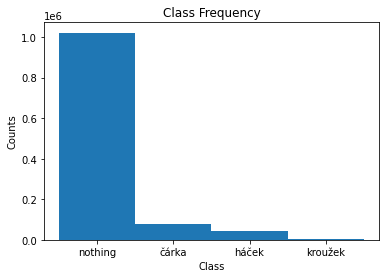

{'nothing': 1021576, 'čárka': 78545, 'háček': 42728, 'kroužek': 2601}
{'nothing': 0.8918556026015976, 'čárka': 0.06857130385438037, 'háček': 0.03730237024750098, 'kroužek': 0.002270723296521018}


In [8]:
from solution import distribution

classname_to_count = distribution(
    train_data=train_data, 
    classlabel_to_classname=classlabel_to_classname, 
    char_to_classlabel=char_to_classlabel,
)
print(classname_to_count)

all_count = sum(classname_to_count.values())
classname_to_percentage = {
    class_name: class_count/all_count 
    for class_name, class_count in classname_to_count.items()
}
print(classname_to_percentage)

So, defaulting to nothing class will give us ~0.89 accuracy. Definitely not bad for a start.

## 1.2 Sliding windows (3 points)

The first model is based on sliding windows, e.g. it considers the current character and two characters to the left and two characters to the right for context.
You should also add padding tokens to the left and to the right so that you can classify the corner characters as well:

```
__Cer -> HOOK
_cErv -> NOTHING
ceRve -> NOTHING
erVen -> NOTHING
rvEne -> NOTHING
veNeh -> NOTHING
enEho -> SIMPLE ACCENT
neHo_ -> NOTHING
ehO__ -> NOTHING
```


Build a sliding-window neural network with the best architecture and hyperparameters and report your accuracies on train and dev datasets.
Additionally, provide the output for the test file.

In [9]:
#Global params
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PADDING_SYMBOL = "_"
ALPHABET_SIZE = 26

#Common NN params
NUM_CLASSES = 4
DROPOUT = 0.25

# FFNN params
FORCE_RETRAIN_FFNN = False
FFNN_BEST_MODEL_PATH = 'best-model-ffnn.pt'
FFNN_EPOCHS = 50
FFNN_BATCH_SIZE = 128
FFNN_INPUT_SIZE = 130

# RNN params
FORCE_RETRAIN_RNN = False
RNN_BEST_MODEL_PATH = 'best-model-rnn.pt'
RNN_EPOCHS = 30
RNN_HIDDEN_SIZE = 32

In [10]:
from solution import prepare_sliding_data

X_train, y_train = prepare_sliding_data(train_data, char_to_classlabel)
X_dev, y_dev = prepare_sliding_data(dev_data, char_to_classlabel)
X_test = prepare_sliding_data(test_data, char_to_classlabel)[0]

In [11]:
X_train[0], y_train[0], len(X_train), len(X_dev), len(X_test)

('__nei', 0, 1145450, 190499, 169901)

In [12]:
from solution import one_hot_encode

sample_encoding = one_hot_encode(X_train[0])
print(X_train[0], len(sample_encoding))

__nei 130


In [13]:
from solution import CustomSlidingDataset
from torch.utils.data import DataLoader

train_dataset = CustomSlidingDataset(X_train, y_train)
validation_dataset = CustomSlidingDataset(X_dev, y_dev)

train_dataloader = DataLoader(train_dataset, batch_size=FFNN_BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=FFNN_BATCH_SIZE*4, shuffle=True)

In [14]:
from solution import run_train_and_val_ffnn, DiacriticFFNN, validation_loop_ffnn


if not FORCE_RETRAIN_FFNN and not os.path.isfile(FFNN_BEST_MODEL_PATH):
    wget.download(f'https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Neural_Networks/HW9_data/{FFNN_BEST_MODEL_PATH}', FFNN_BEST_MODEL_PATH)

model = DiacriticFFNN().to(DEVICE)

if not FORCE_RETRAIN_FFNN and os.path.isfile(FFNN_BEST_MODEL_PATH):
    model.load_state_dict(torch.load(FFNN_BEST_MODEL_PATH, map_location=DEVICE))
    # run short validation to report metrics and check if model is working
    ffnn_best_metrics = \
        validation_loop_ffnn(model=model, 
                             dataloader=validation_dataloader, 
                             loss_fn = nn.CrossEntropyLoss())
    print()
    print(ffnn_best_metrics)
else:
    ffnn_best_model_path, ffnn_best_epoch, ffnn_best_metrics = \
        run_train_and_val_ffnn(model, train_dataloader,
                               validation_dataloader,
                               epochs=FFNN_EPOCHS,
                               best_model_path=FFNN_BEST_MODEL_PATH)
    
    print()
    print(ffnn_best_model_path, ffnn_best_epoch, ffnn_best_metrics)

100%|██████████| 373/373 [00:01<00:00, 215.61it/s]


{'loss': 0.10470302506342491, 'accuracy': 0.9600050393965323, 'predicted_labels': defaultdict(<class 'int'>, {0: 173081, 2: 5972, 1: 11157, 3: 289}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 2: 7002, 1: 12887, 3: 462})}


In [15]:
from solution import predict_result_fnn
          
predict_result_fnn(X_test, model)

100%|██████████| 169901/169901 [01:18<00:00, 2173.62it/s]


## 1.3 RNN (5 points)

Secondly, build a character-level recurrent neural network many (n) to many (n) which performs the classification:
```
cerveny -> HNNNNNANN
```

Be careful, this will require you to either pad the input sequence (then you will also need to backpropagate only from the original sequence and disregard padded values) or use some other trick.

You can use all the tricks you know for both models. For the RNN-based one, you can use non-vanilla RNN cells (such as LSTM or GRU). The recurrent part should be followed-up with a classification FFNN. Again, try to find the best architecture and hyperparameters, report train and dev results.

In both cases, describe in text the architecture of your models.

Provide also an output for the test file, one word per file, with diacritics (e.g. `červeného`). This is mandatory.

In [16]:
from solution import prepare_rnn_data

X_train_rnn, y_train_rnn = prepare_rnn_data(train_data, char_to_classlabel)
X_dev_rnn, y_dev_rnn = prepare_rnn_data(dev_data, char_to_classlabel)
X_test_rnn = prepare_rnn_data(test_data, char_to_classlabel)[0]

In [17]:
len(X_train_rnn), len(X_dev_rnn), len(X_test_rnn), y_train_rnn[1]

(90000, 15000, 13376, tensor([0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0]))

In [18]:
from solution import DiacriticsRNN

rnn_model = DiacriticsRNN(input_size=ALPHABET_SIZE, hidden_size=RNN_HIDDEN_SIZE,
                          output_size=NUM_CLASSES, dropout=DROPOUT)

# check if forward path works
for input_tensor in X_train_rnn:
    with torch.no_grad():
        model_output = rnn_model.forward(input_tensor)
        print(input_tensor.shape, model_output.shape)
        break

torch.Size([11, 26]) torch.Size([11, 4])


In [19]:
from solution import run_train_and_val_rnn, validation_loop_rnn

if not FORCE_RETRAIN_RNN and not os.path.isfile(RNN_BEST_MODEL_PATH):
    wget.download(f'https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Neural_Networks/HW9_data/{RNN_BEST_MODEL_PATH}', RNN_BEST_MODEL_PATH)


rnn_model = DiacriticsRNN(input_size=ALPHABET_SIZE, hidden_size=RNN_HIDDEN_SIZE,
                          output_size=NUM_CLASSES, dropout=DROPOUT)

if not FORCE_RETRAIN_RNN and os.path.isfile(RNN_BEST_MODEL_PATH):
    rnn_model.load_state_dict(torch.load(RNN_BEST_MODEL_PATH, map_location=DEVICE))
    # run short validation to report metrics and check if model is working
    best_rnn_metrics = \
        validation_loop_rnn(model=rnn_model, x_data=X_dev_rnn, 
                            y_data=y_dev_rnn, loss_fn = nn.CrossEntropyLoss())
    
    print()
    print(best_rnn_metrics)
else:
    path_to_best_rnn_model_file, best_rnn_epoch, best_rnn_metrics = \
        run_train_and_val_rnn(rnn_model, X_train_rnn,
                              y_train_rnn, X_dev_rnn,
                              y_dev_rnn, epochs=RNN_EPOCHS,
                              path_to_best_model_file=RNN_BEST_MODEL_PATH)
    
    print()
    print(path_to_best_rnn_model_file, best_rnn_epoch, best_rnn_metrics)

15000it [00:12, 1234.09it/s]


{'loss': 0.16698830330783676, 'accuracy': 0.9373330043727264, 'predicted_labels': defaultdict(<class 'int'>, {0: 177305, 2: 3462, 1: 9723, 3: 9}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}


Comments:
1. I have stopped training after 12 epochs.
2. Gradient accumulation does not work for me:
```
RNN_BATCH_SIZE = 32
model.train()
for batch_idx, (x_tensor, gold_label_tensor) in enumerate(tqdm(zip(x_data, y_data))):
    # Compute prediction and loss
    pred_output = model(x_tensor)
    loss = loss_fn(pred_output, gold_label_tensor) / RNN_BATCH_SIZE
    loss.backward()

    if ((batch_idx + 1) % RNN_BATCH_SIZE == 0) or (batch_idx + 1 == dataset_size):
        optimizer.step()
        optimizer.zero_grad()
```

```
Epoch 1

Train metrics:  {'loss': 0.037127886973238655, 'accuracy': 0.6176297524990179, 'predicted_labels': defaultdict(<class 'int'>, {1: 267872, 3: 102822, 2: 7549, 0: 767207}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}

Validation metrics:  {'loss': 0.6670510955462853, 'accuracy': 0.8931700428873642, 'predicted_labels': defaultdict(<class 'int'>, {0: 190499}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

-------------------------------
1
90000it [02:18, 651.34it/s]
15000it [00:04, 3333.32it/s]

 Epoch 2

Train metrics:  {'loss': 0.014869989560646677, 'accuracy': 0.8918556026015976, 'predicted_labels': defaultdict(<class 'int'>, {0: 1145450}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}

Validation metrics:  {'loss': 0.4108426091613869, 'accuracy': 0.8931700428873642, 'predicted_labels': defaultdict(<class 'int'>, {0: 190499}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}

 Epoch 3

Train metrics:  {'loss': 0.012825845986056244, 'accuracy': 0.8918556026015976, 'predicted_labels': defaultdict(<class 'int'>, {0: 1145450}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}

Validation metrics:  {'loss': 0.3944781747162342, 'accuracy': 0.8931700428873642, 'predicted_labels': defaultdict(<class 'int'>, {0: 190499}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}



Epoch 4

Train metrics:  {'loss': 0.012440418811670195, 'accuracy': 0.8918556026015976, 'predicted_labels': defaultdict(<class 'int'>, {0: 1145450}), 'gold_labels': defaultdict(<class 'int'>, {0: 1021576, 1: 78545, 2: 42728, 3: 2601})}

Validation metrics:  {'loss': 0.38559575219663483, 'accuracy': 0.8931700428873642, 'predicted_labels': defaultdict(<class 'int'>, {0: 190499}), 'gold_labels': defaultdict(<class 'int'>, {0: 170148, 1: 12887, 2: 7002, 3: 462})}
```

In [20]:
from solution import predict_result_rnn      
          
predict_result_rnn(test_data, X_test_rnn, rnn_model, path_to_best_model=RNN_BEST_MODEL_PATH)

13376it [00:10, 1268.08it/s]


# 2 Theory (1 point)

Find NLP tasks (apart form diacritization) that match the following RNN architecture and describe them in detail:
- Many (n) to many (n)
- Many (n) to many (m), m $\neq$ n
- Many (n) to one


- Many (n) to many (n) - POS-tagging <br>
This RNN has synced sequence input and synced sequence output where both lengths are equal. For POS-tagging for example, word tokennization is processed on a sentence and a POS will be tagged for each token. 
Example: sentence: computational linguistics is interdisciplinary
tokenization: \['computational', 'linguistics', 'is', 'interdisciplinary'\]
pos-tag: \['adjective', 'noun', 'verb', 'adjective'\] Each output node can measure the loss, so averaging the losses (sequence loss) can be used for training. Padding tokens may need to be considered for removal.
- Many (n) to many (m), m $\neq$ n - Machine Translation <br>
This RNN has sequence input and sequence output. For machine translation, the RNN has LSTM layers or architecture, where there is a self-loop with gated weights (forget gate, external input gate, and output gate). Cells are connected recurrently to each other, replacing the usual hidden units of ordinary recurrent networks. The layer is also split into two parts: the encoder that takes the input and the decoder that reads and translates to the output target language. 
- Many (n) to one - Sentiment Analysis <br>
This RNN has sequence input and fixed size (one) output. For sentiment analysis, the input would be a sequence like a sentence and the output would be a classification label of positive or negative sentiment. The sentence would be converted into a numerical vector using an embedding layer and encoded with a bidirectional RNN. 

# Final remarks

## Accuracies

It is important that your models perform well:

||Dev accuracy|
|-|-|
|Minimum for full points on sliding windows|96.0%|
|Minimum for full points on RNN|97.0%|
|SoTA [Náplava et al. 2021](https://ufal.mff.cuni.cz/pbml/116/art-naplava-straka-strakova.pdf)|99.2% (different dataset)|
|Best student solution from Charles University|99.1% (different dataset)|
|A foreign student living in Prague for 5 years|92.0% (Vilém's personal feeling)|

We will evaluate your test results and top 2 groups will get +2 points.
The next 2 groups will get +1 point.

## Runtime

You don't need to use a GPU.
The training on a 2019 high-end CPU takes 60 minutes.
If you really need more compute power (you shouldn't need to need it) then you can use Google collab.
Nevertheless, we suggest you to first work on a subset of data for a faster development loop.

In [21]:
! rm $train_filename $dev_filename $test_filename rnn_predictions.txt sliding_predictions.txt $RNN_BEST_MODEL_PATH $FFNN_BEST_MODEL_PATH